# Extract embeddings, PCA

May need to restart kernel for each dataset if worker error

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.models import resnet
from torchvision.models.resnet import ResNet50_Weights
import pandas as pd

# import my_custom_dataset_eval from 
import sys
sys.path.append('/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/evaluation/')
from my_custom_dataset_eval import CTDataset_test

In [2]:
starting_weights = "/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/logs/exman-train.py/runs/baseline/checkpoint-5100.pth.tar"

cfg = {'starting_weights': starting_weights, 'finetune': False,
       'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
       'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json',
       'test_dataset': 'test_kenya',#######################
       'num_classes': 2, #####################
       'num_workers':4} 

### Load model

In [4]:

class CustomResNet50(nn.Module):

    def __init__(self, num_classes):
        '''
            Constructor of the model. Here, we initialize the model's
            architecture (layers).
        '''
        super(CustomResNet50, self).__init__()

        # load imagenet weights
        self.feature_extractor = resnet.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)


        # replace the very last layer from the original, 1000-class output
        # ImageNet to a new one that outputs num_classes
        last_layer = self.feature_extractor.fc                          # tip: print(self.feature_extractor) to get info on how model is set up
        in_features = last_layer.in_features                            # number of input dimensions to last (classifier) layer
        self.feature_extractor.fc = nn.Identity()                       # discard last layer...

        self.classifier = nn.Linear(in_features, num_classes)           # ...and create a new one
    

    def forward(self, x):
        '''
            Forward pass. Here, we define how to apply our model. It's basically
            applying our modified ResNet-18 on the input tensor ("x") and then
            apply the final classifier layer on the ResNet-18 output to get our
            num_classes prediction.
        '''
        # x.size(): [B x 3 x W x H]
        features = self.feature_extractor(x)    # features.size(): [B x 512 x W x H]
        prediction = self.classifier(features)  # prediction.size(): [B x num_classes]

        return prediction

In [5]:
# Initialize your model
model_instance = CustomResNet50(cfg['num_classes'])

### Dataloader

In [6]:
split = 'test_data'
transform = False
train_percent = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#dataset = CTDataset_train(cfg, split=split, transform=transform, train_percent=train_percent)
dataset_instance = CTDataset_test(cfg, split=split, transform=transform, train_percent=train_percent)

In [7]:
def get_dataloader(cfg, split, transform, train_percent, batch_size, shuffle, num_workers):
    
    dataset = CTDataset_test(cfg, split, transform, train_percent)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle
    )

    return dataloader

sample_loader = get_dataloader(cfg, split, transform=False, train_percent = train_percent, batch_size=64, shuffle=False, num_workers=cfg['num_workers']) 


Does the below cell error? May need to restart kernel

### Extract embeddings

In [8]:
def extract_multiple_embeddings(model, dataloader, device):
    model.eval()
    model.to(device)  # move to GPU
    all_embeddings = []
    labels = []
    
    with torch.no_grad():
        for i, (audio, classes) in enumerate(dataloader):
            audio = audio.to(device)  # move to GPU
            # The following line is changed to use feature_extractor
            embeddings = model.feature_extractor(audio)  
            all_embeddings.extend(embeddings.cpu().numpy())
            labels.extend(classes.cpu().numpy())
            
    return all_embeddings, labels

embeddings, labels = extract_multiple_embeddings(model_instance, sample_loader, device)


### Save the embeddings

In [10]:
# Assuming embeddings is your list of lists, each of 2048 features
# And labels is your list of labels

# Create a DataFrame
df = pd.DataFrame(embeddings, columns=[f'Feature_{i+1}' for i in range(2048)])

# Insert labels as the first column
df.insert(0, 'Label', labels)

# Save the DataFrame to CSV
df.to_csv('raw_embeddings/' + 'ImageNet-' + cfg['test_dataset'][5:] + '-embeddings.csv', index=False)
df

,Label,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_2039,Feature_2040,Feature_2041,Feature_2042,Feature_2043,Feature_2044,Feature_2045,Feature_2046,Feature_2047,Feature_2048
0,0,0.408951,0.023364,0.050553,0.023363,0.046181,0.181775,0.334256,0.0,0.191301,...,0.006197,0.008648,0.0,0.074497,0.011762,0.031635,0.017565,0.068124,0.038609,0.012271
1,0,0.414981,0.019828,0.047222,0.021585,0.046929,0.184887,0.334899,0.0,0.187661,...,0.005663,0.008608,0.0,0.069757,0.011339,0.031604,0.017685,0.067328,0.036188,0.012033
2,1,0.409793,0.023297,0.050817,0.023483,0.045930,0.182718,0.333932,0.0,0.191016,...,0.006241,0.008682,0.0,0.074771,0.012008,0.031738,0.017747,0.067259,0.038626,0.012295
3,1,0.409952,0.023210,0.050569,0.023575,0.045916,0.182780,0.333468,0.0,0.191438,...,0.006271,0.008673,0.0,0.074748,0.011967,0.031786,0.017795,0.067309,0.038755,0.012305
4,1,0.410221,0.023035,0.050891,0.023269,0.045970,0.182561,0.333635,0.0,0.191874,...,0.006246,0.008590,0.0,0.074849,0.012019,0.031746,0.017853,0.067335,0.038898,0.012274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,0,0.410191,0.023082,0.050495,0.023676,0.045837,0.182343,0.332943,0.0,0.191491,...,0.006243,0.008694,0.0,0.074775,0.012046,0.031673,0.017658,0.067277,0.038795,0.012263
817,1,0.409919,0.023064,0.050699,0.023526,0.045824,0.182992,0.333682,0.0,0.191173,...,0.006228,0.008671,0.0,0.074709,0.012017,0.031713,0.017699,0.067266,0.038753,0.012305
818,0,0.410382,0.023033,0.050878,0.023335,0.046071,0.182961,0.333516,0.0,0.191398,...,0.006250,0.008613,0.0,0.075062,0.012186,0.031663,0.017750,0.067013,0.038722,0.012304
819,1,0.409967,0.023281,0.050696,0.023517,0.045880,0.182806,0.333979,0.0,0.191424,...,0.006263,0.008696,0.0,0.074794,0.012073,0.031742,0.017653,0.067298,0.038630,0.012385


### PCA plot

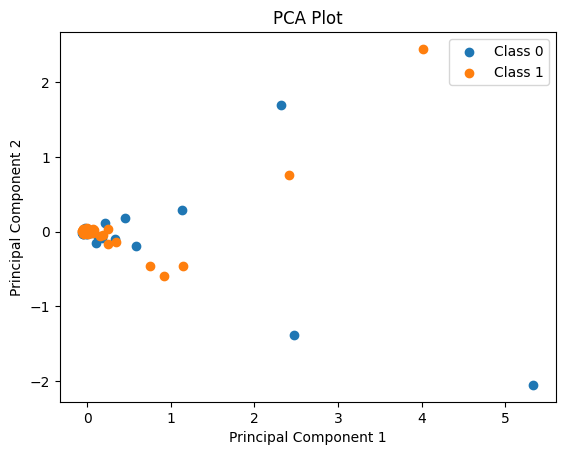

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings to a NumPy array for easier manipulation
embeddings = np.array(embeddings)

# Initialize PCA and the X vector for dimensionality reduction
pca = PCA(n_components=2)

# Fit and transform the embeddings to get new 2D representations
embeddings_pca = pca.fit_transform(embeddings)

# Create a scatter plot
classes = np.unique(labels)  # Extract unique labels to identify distinct classes
for class_label in classes:
    idx = np.where(np.array(labels) == class_label)  # Get index where class label is found
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], label=f"Class {class_label}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="upper right")
plt.title("PCA Plot")
plt.show()